# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import matplotlib as mpl

## Data Pipeline

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    df = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return df.values

# load a list of files into a 3D array of [observations, timesteps, features(x,y,z)]
def load_group(files, prefix=''):
    loaded = list()
    for f in files:
        data = load_file(prefix + f)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    files = list()
    # body acceleration
    files += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    files += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # total acceleration
    files += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # load input data
    X = load_group(files, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    # load all train
    X_train, y_train = load_dataset_group('train', prefix)
    # load all test
    X_test, y_test = load_dataset_group('test', prefix)
    
    """
    # zero-offset class values
    y_train = y_train - 1
    y_test = y_test - 1
    # one hot encode y
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    """
    
    print(f"""Dataset loaded.
Training Set:
X_train {X_train.shape} y_train {y_train.shape}
Test Set:
X_test {X_test.shape} y_test {y_test.shape}""")
    return X_train, y_train, X_test, y_test

In [3]:
X_train, y_train, X_test, y_test = load_dataset(prefix="data/")

Dataset loaded.
Training Set:
X_train (7352, 128, 9) y_train (7352, 1)
Test Set:
X_test (2947, 128, 9) y_test (2947, 1)


## Data Visualisation

In [4]:
activity = {
        1: 'Walking',
        2: 'Walking Upstairs',
        3: 'Walking Downstairs',
        4: 'Sitting',
        5: 'Standing',
        6: 'Laying'}

In [5]:
def activities(obs):
    return activity[int(y_train[obs])]

In [6]:
def features(feature):
    f={"Body acceleration": 0, "Gyro": 1, "Total acceleration": 2}
    return f[feature]

In [7]:
# Example for each activity
sample=[777, 666, 818, 0,6666,66]
[activity[int(y_train[i])] for i in sample]

['Walking',
 'Walking Upstairs',
 'Walking Downstairs',
 'Standing',
 'Sitting',
 'Laying']

### Feature Signals

In [8]:
# Grab values for graphs
def get_values(y_values, T, N, f_s, sample_rate):
    y_values = y_values
    x_values = [sample_rate * kk for kk in range(0,len(y_values))]
    return x_values, y_values

In [9]:
# Display x,y,z as separate lines for each feature
def signal_viz(obs):
    N = 128 # number of timesteps
    f_s = 50 # overlapped percentage
    t_n = 2.56 # time
    T = t_n / N
    sample_rate = 1 / f_s
    
    labels = ['x-component', 'y-component', 'z-component']
    colors = ['r', 'g', 'b']
    suptitle = "Different signals for the activity: {}"
    graph_name="graph/Signals {}.png" 
    xlabel = 'Time [sec]'
    ylabel = 'Amplitude'
    axtitles = ['Body acceleration', 'Gyro', 'Total acceleration']
    activity_name = activities(obs)
    
    sns.set(style="white", font_scale = 1.7)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,8))


    for comp_no in range(0,9):
            col_no = comp_no // 3
            plot_no = comp_no % 3
            color = colors[plot_no]
            label = labels[plot_no]

            axtitle  = axtitles[col_no]

            ax = axes[col_no]
            ax.set_title(axtitle)
            ax.set_xlabel(xlabel)
            if col_no == 0:
                ax.set_ylabel(ylabel, fontsize=16)

            signal_component = X_train[obs][:, comp_no]
            x_values, y_values = get_values(signal_component, T, N, f_s, sample_rate)
            ax.plot(x_values, y_values, linestyle='-', color=color, label=label)  
            if col_no == 2:
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.suptitle(suptitle.format(activity_name))    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90, hspace=0.6)
    #plt.savefig(graph_name.format(activity_name) , transparent=True)
    plt.show()    

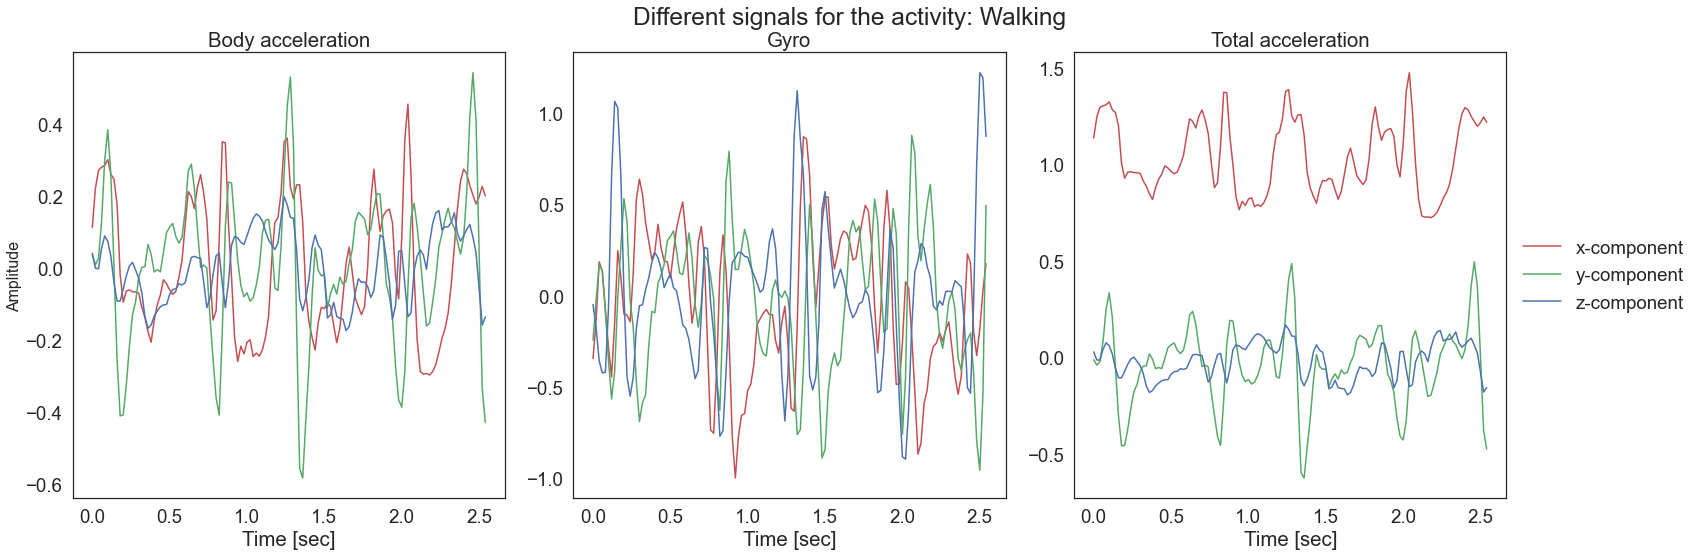

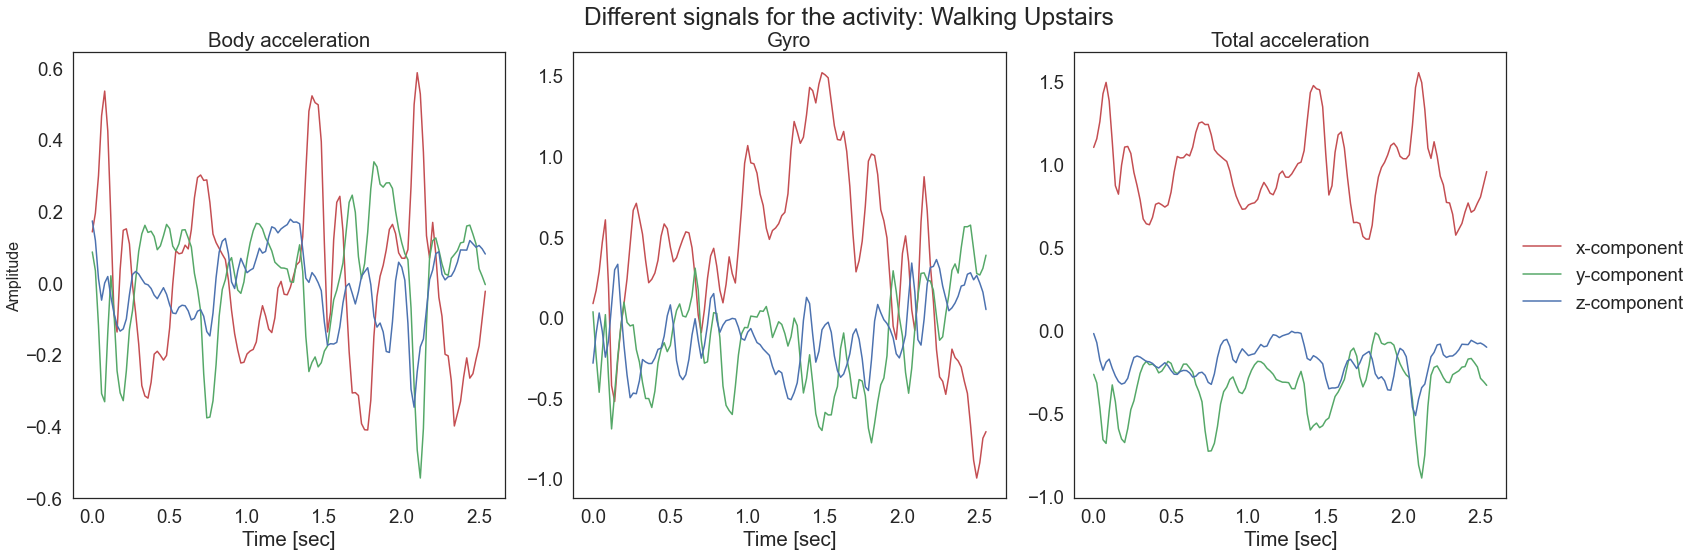

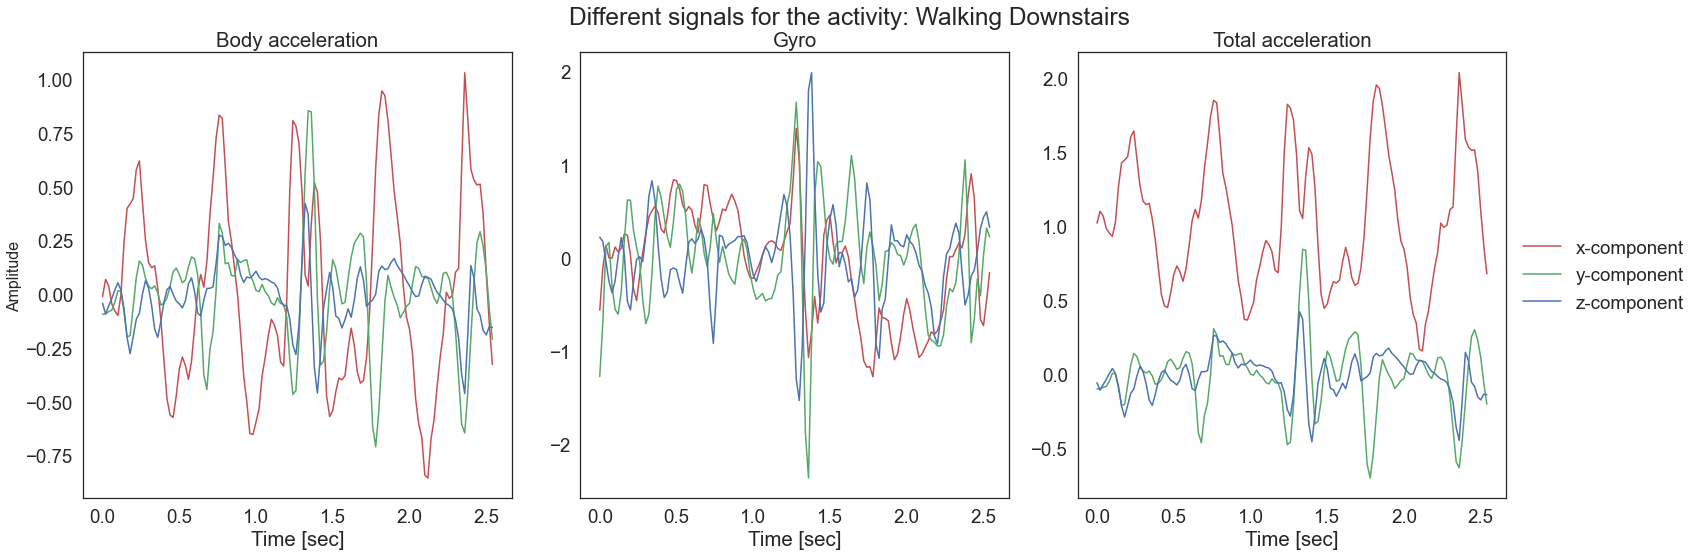

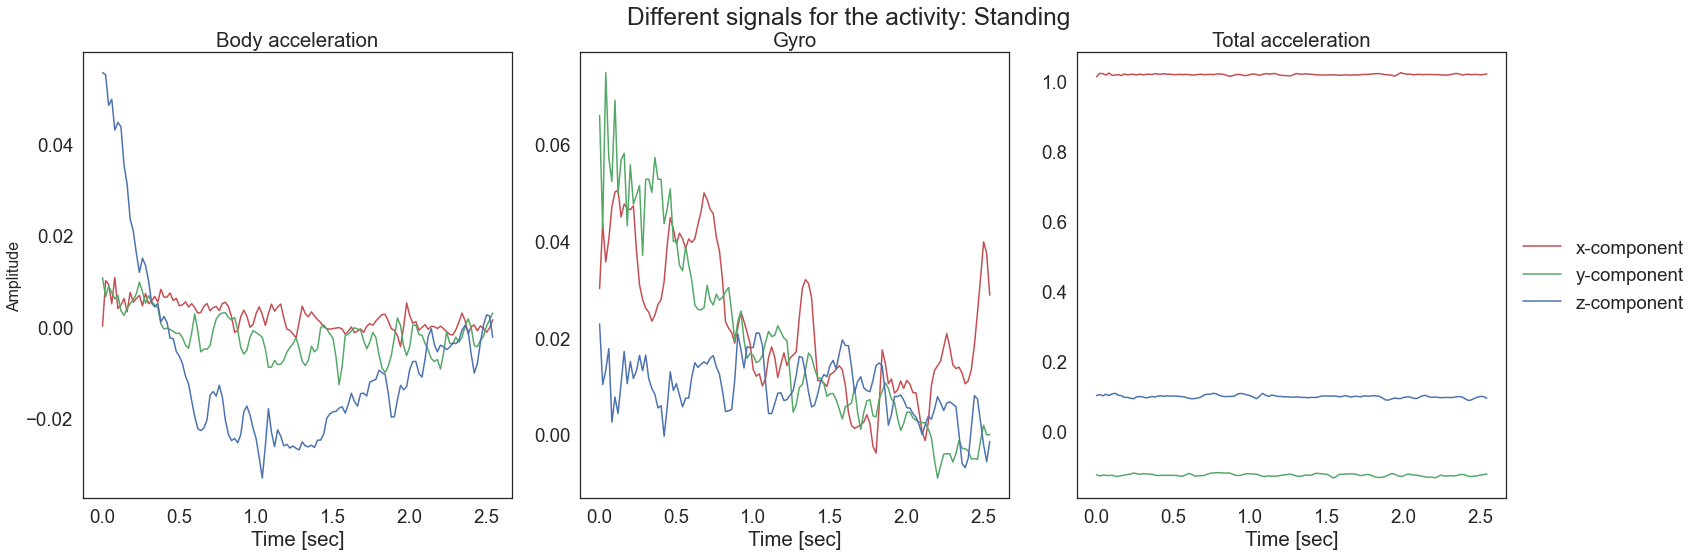

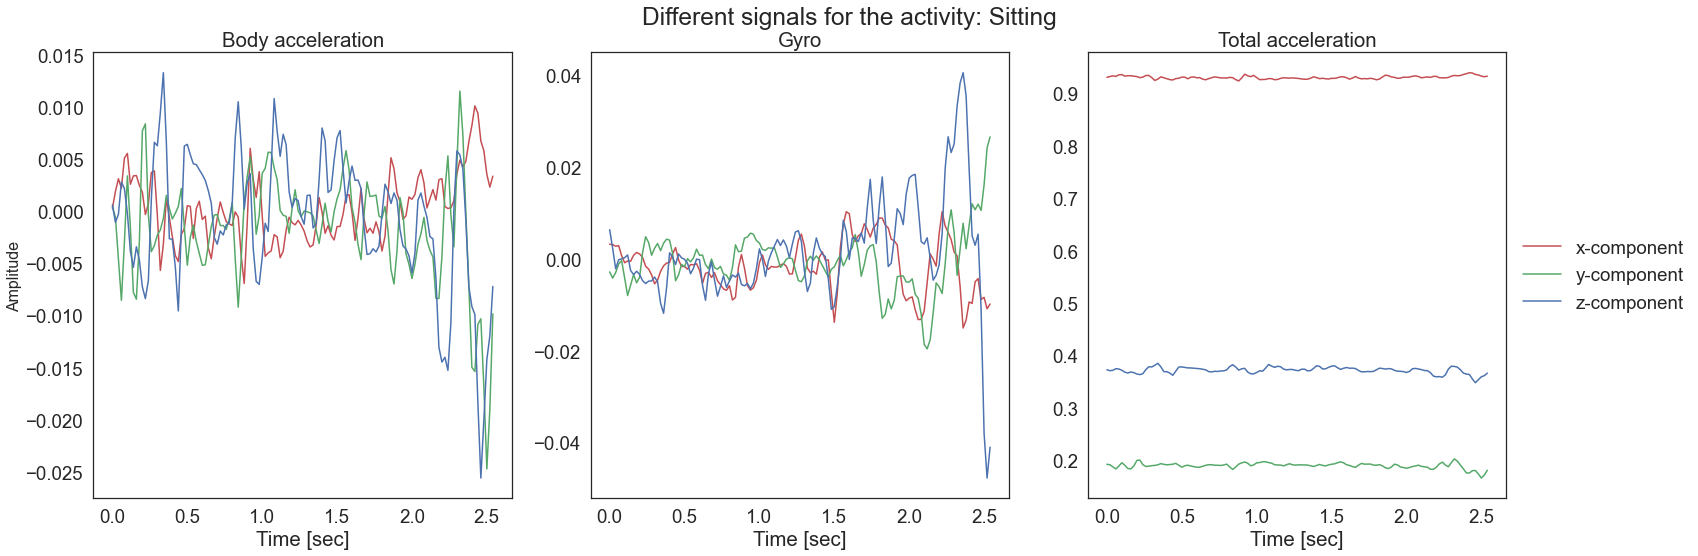

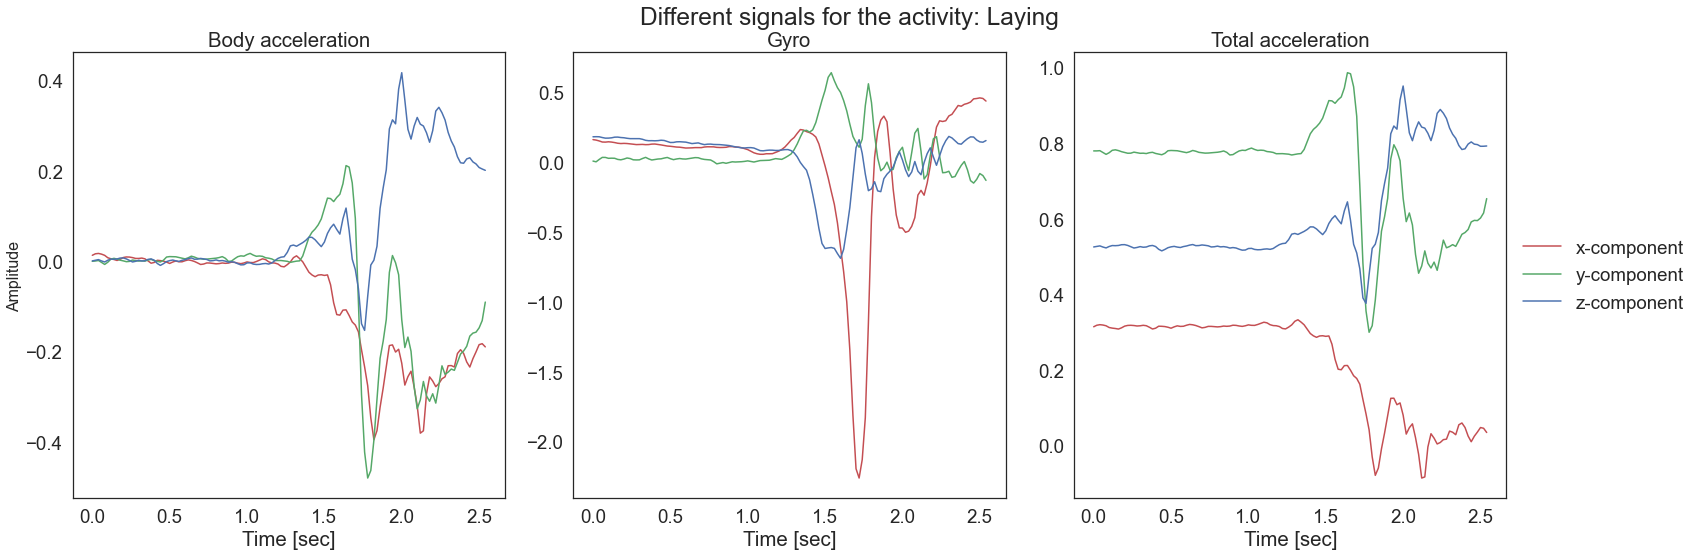

In [10]:
for i in sample:
    signal_viz(i)

### 3D Plot of Feature Signal

In [21]:
# Plot the selected feature signal in 3D
def signal_3dviz(obs,feature):
    graph_name="graph/3D {} {}.png"
    activity_name = activities(obs)
    
    i=features(feature)
    
    """PowerPoint Slide prepreations
    sns.set(style="ticks", font_scale=2)
    plt.style.use("dark_background")"""
    sns.set(style="white", font_scale = 1.5)
    fig = plt.figure(figsize=(6,6))
    ax = fig.gca(projection="3d")    
    x = X_train[obs][:, i*3+0]
    y = X_train[obs][:, i*3+1]
    z = X_train[obs][:, i*3+2]
    ax.plot(x, y, z, label=feature, color="r")
    ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
    plt.title(activity_name)
    plt.xlabel("x")
    plt.ylabel("y")
    ax.set_zlabel("z")
    # Get rid of colored axes planes
    # First remove fill
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    """# Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')"""

    # Bonus: To get rid of the grid as well:
    ax.grid(False)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(12)
    plt.savefig(graph_name.format(feature, activity_name) , transparent=True)
    plt.show()

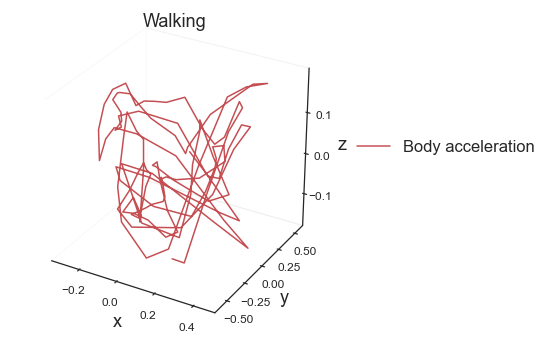

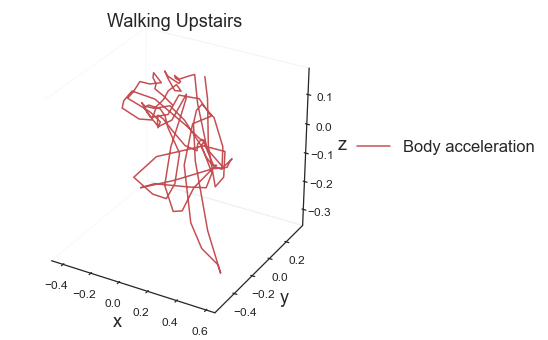

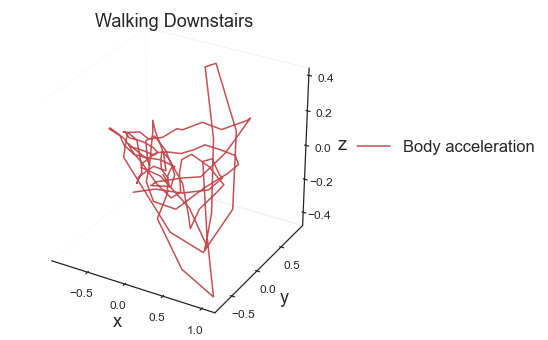

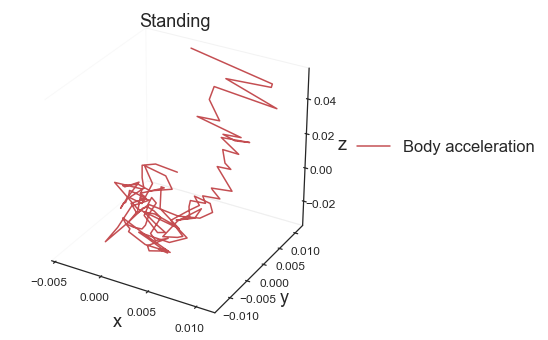

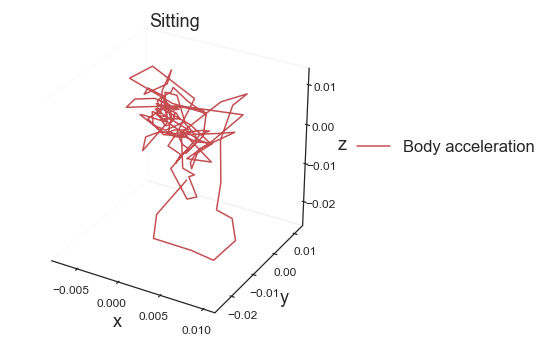

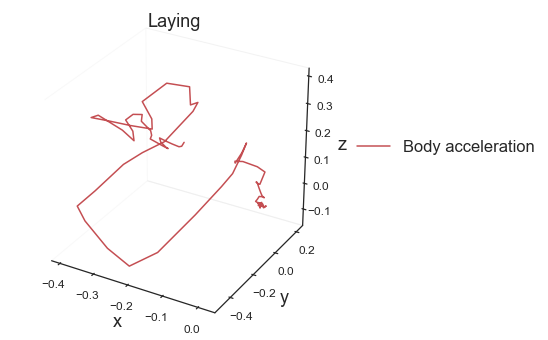

In [22]:
for i in sample:
    signal_3dviz(i, "Body acceleration")

### Distance to Origin Feature Signal

In [13]:
# Calculate the distance of each timesteps to origin (0,0,0)
def distance_viz(obs, feature):
    graph_name="graph/distance {} {}.png"
    activity_name = activities(obs)
    
    i=features(feature)
    
    """PowerPoint preparation
    sns.set(style="ticks", font_scale=2)
    plt.style.use("dark_background")"""
    sns.set(style="white", font_scale = 1.2)
    fig = plt.figure(figsize=(8,6))
    x = X_train[obs][:, i*3+0]
    y = X_train[obs][:, i*3+1]
    z = X_train[obs][:, i*3+2]
    plt.plot((x**2+y**2+z**2)**0.5, label=feature)
    plt.legend()
    plt.title(activity_name)
    plt.xlabel("Timesteps")
    plt.ylabel("Distance")
    plt.savefig(graph_name.format(feature, activity_name) , transparent=True)
    plt.show()

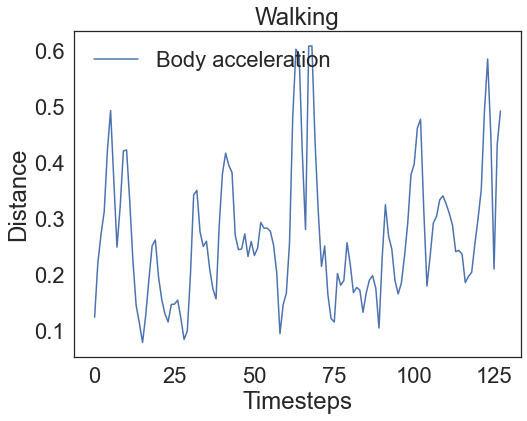

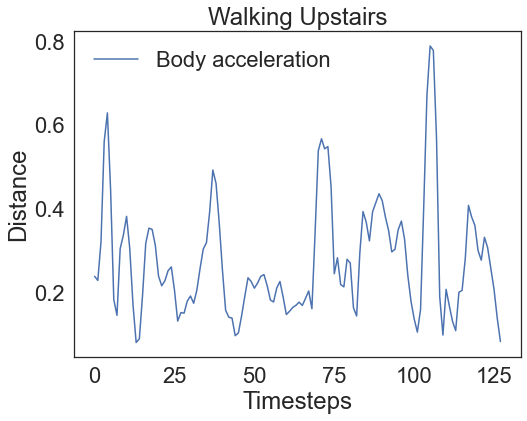

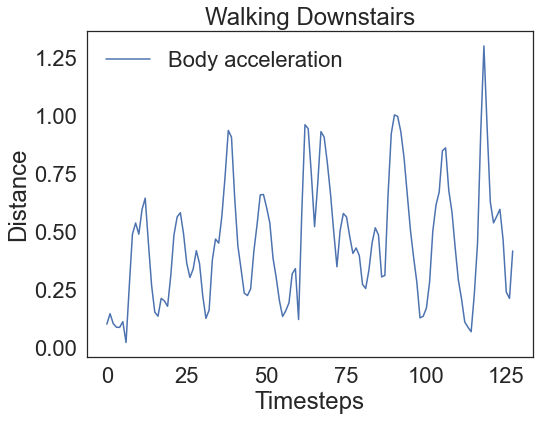

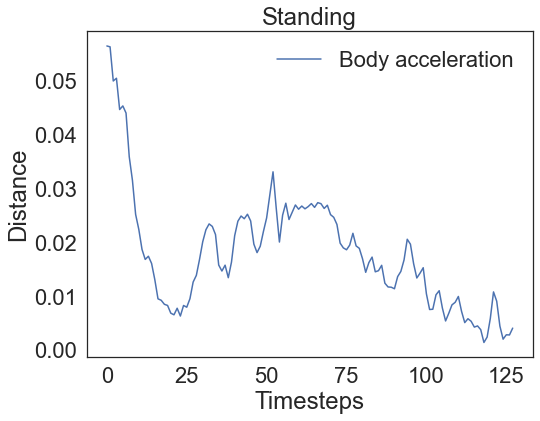

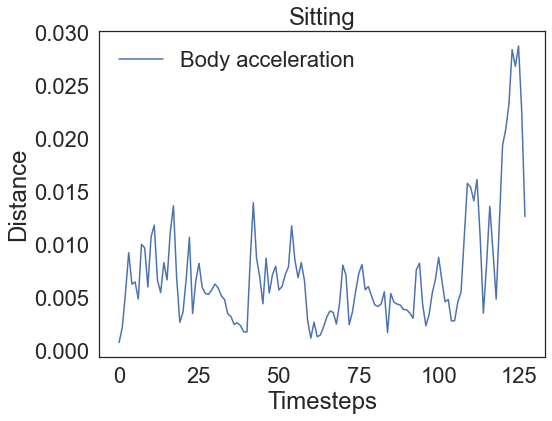

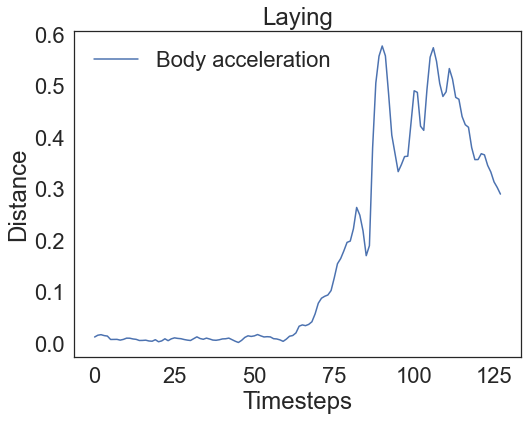

In [14]:
for i in sample:
    distance_viz(i, "Body acceleration")

### Observations by Activity

In [15]:
def y_graph():
    y=pd.DataFrame(np.concatenate((y_train, y_test)), columns=["Activity"])
    y["Activity"]=y.Activity.map(activity)
    """PowerPoint preparation
    sns.set(style="ticks", font_scale=3)
    plt.style.use("dark_background")"""
    sns.set(style="white", font_scale=3)
    f, ax = plt.subplots(figsize=(40,15))
    sns.countplot(data=y, y="Activity")
    plt.title("Observations by Activity")
    plt.show()
    #plt.savefig("graph/activity count.png", transparent=True)

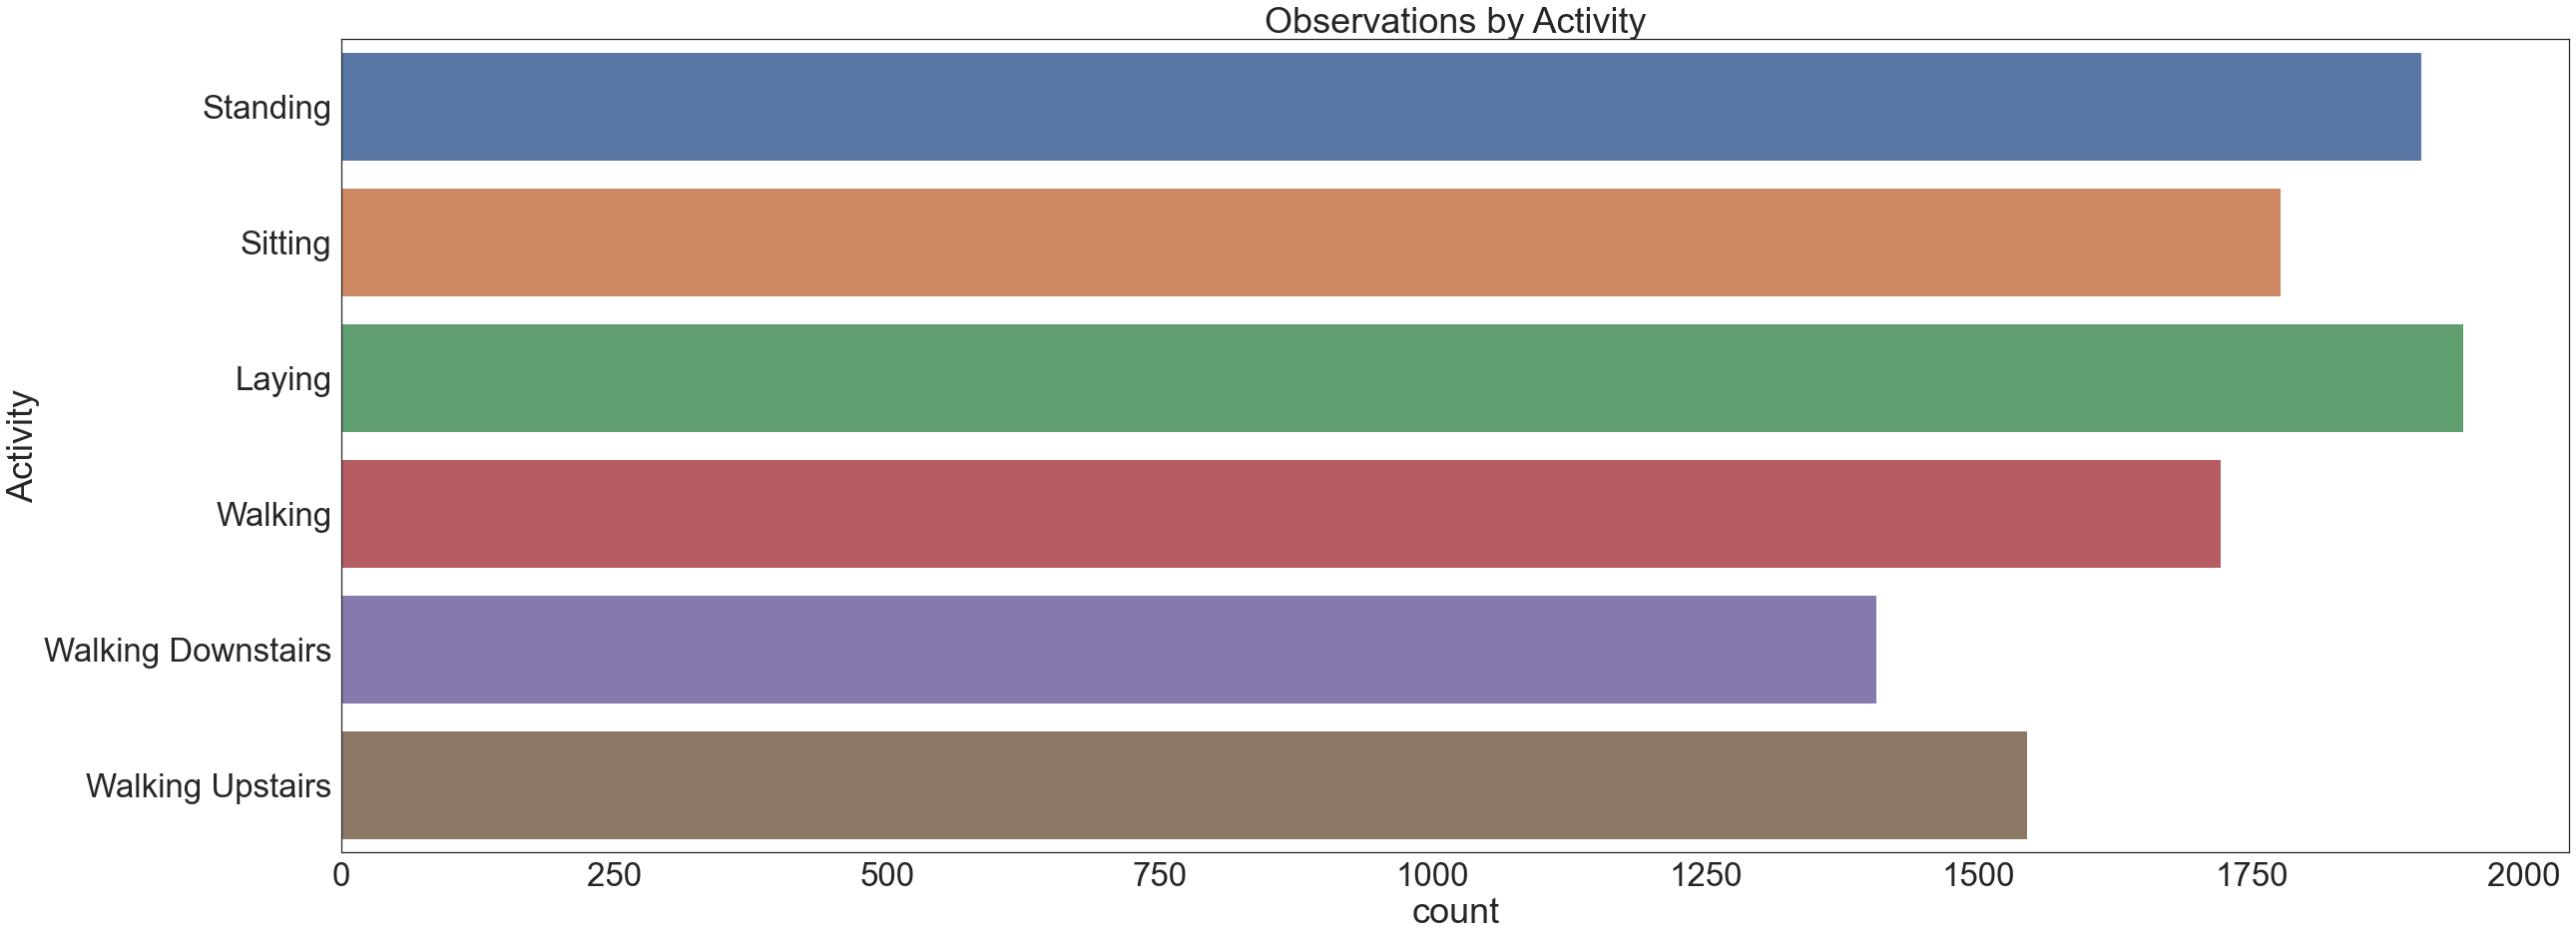

In [16]:
y_graph()